# SBU CSE 352 - HW 4 - Machine Learning From Scratch


Name: Cody Lam

I understand that my submission needs to be my own work: C.L.

I understand that ChatGPT / Copilot / other AI tools are not allowed: C.L.

---

## Instructions

Total Points: 100

1. Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy and built-in packages like random). Submit the completely rendered notebook as a HTML file.

  **Important:** Do not use scikit-learn or other packages with ML built in. The point of this is to be a learning exercise. Using linear algebra from numpy is okay (things like matrix operations or pseudoinverse, for example, but not lstsq).

2. Your notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use matplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Introduction

You will implement several machine learning algorithms and evaluate their accuracy. This will be done for a downscaled version of the MNIST digit recognition dataset.

**Like in real life, some of the tasks you will be asked to do may not be possible, at least directly. In these cases, your job is to figure out why it won't work and either propose a fix (best), or provide a clear explanation why it won't work.**

For example, if the problem says to do k-nearest neighbors with a dataset of a billion points, this could require too much time to do each classification so it's infeasible to evaluate its test accuracy. In this case, you could suggest randomly downsample the data to a more manageable size, which will speed things up by may lose some accuracy. In your answer, then, you should describe the problem and how you solved it and the trade-offs.

# Data
First the code below ensures you have access to the training data (a subset of the MNIST images), consisting of 100 handwritten images of each digit.

In [ ]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/ML
!ls

In [ ]:
import matplotlib.pyplot as plt
import pickle

# if the below fails to open, then the data file is not in the current working directory (see above code block)
with open('mini-mnist-1000.pickle', 'rb') as f:
  data = pickle.load(f)

im3 = data['images'][300] # 100 images of each digit
plt.figure(figsize=(2, 2))  # Adjust size as needed
plt.imshow(im3, cmap='gray')
plt.axis('off')
plt.show()

# Downscaling Images

MNIST images are originally 28x28. We will train our models not just on the original images, but also on downscaled images with the following sizes: 14x14, 7x7, 4x4, 2x2. The next code block shows one way to do downscaling. As you can tell from the output, we cannot expect our model's accuracy will be too high on lower resolution versions, although it's unclear how much better you can do than random chance, which should have a 10% accuracy.

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Function to downscale an image to different sizes
def downscale_image(image, downscaled_size):
    block_size = 28 // downscaled_size
    downscaled = np.zeros((downscaled_size, downscaled_size))
    for i in range(downscaled_size):
        for j in range(downscaled_size):
            # Calculate the average for each block
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            downscaled[i, j] = np.mean(block)
    return downscaled

# Load the dataset (assuming this file is in your working directory)
with open('mini-mnist-1000.pickle', 'rb') as f:
    data = pickle.load(f)

images = data['images']  # a list of 1000 numpy image matrices
labels = data['labels']  # a list of 1000 integer labels

# Select 3 "random" indices from the dataset
random_indices = [300, 500, 200]

# Downscale the images to multiple sizes and display them
sizes = [28, 14, 7, 4, 2]
for index in random_indices:
    fig, axs = plt.subplots(1, len(sizes), figsize=(10, 2))
    for ax, size in zip(axs, sizes):
        downscaled_image = downscale_image(images[index], size)
        ax.imshow(downscaled_image, cmap='gray', vmin=0, vmax=255)
        ax.set_title(f'Size {size}x{size}')
        ax.axis('off')
    plt.show()

---
# Tasks

Your data contains 100 images in each class. When training models, use 80% of training, 10% for validation and 10% for testing. Make sure the data is balanced in each class when splitting.

---
## Task 1: Linear Classifier [20 points]

First, implement a linear classifier. The simplest way to do this is to adapt linear regression approaches that we learned about in class, where the output is a real number. For classification, we can let one category be an output of 1.0 and the other -1.0. Then, after the classifier is trained we can use the sign of the output to determine the predicted class.

However, since in MNIST there are multiple classes (10 digits, not just 2), we need to adapt the approach further. We will try both of the following two popular strategies: One-vs-Rest (OvR) and One-vs-One (OvO).

**One-vs-Rest (OvR)** is a strategy for using binary classification algorithms for multiclass problems. In this approach, a separate binary classifier is trained for each class, which predicts whether an instance belongs to that class or not, making it the 'one' against all other classes (the 'rest'). For a new input instance, compute the output of all classifiers. The predicted class is the one whose corresponding classifier gives the highest output value.

**One-vs-One (OvO)** is another strategy where a binary classifier is trained for every pair of classes. If there are N classes, you will train N(N−1)/2 classifiers. For a new input, evaluate it using all N(N−1)/2​ classifiers. Count the number of times each class is predicted over all binary classifications. The class with the highest count is selected as the final prediction.

### Report Results
Report the test accuracy for OvR and OvO, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2. A table may be helpful. Also report any interesting observations.

In [ ]:
import random
import pandas as pd

"""
I first decided to organize the data based on the digits 0-9 and then I would split the data into
train/val/test (80/10/10) for balance and then downscaled to multiple sizes and flattened into 1D feature vectors.
After that I built the linear regression model in order to compare the One-vs-Rest (OvR) and One-vs-One (OvO)
approaches. The One-vs-rest approach was a binary classifier that is trained for each class, which predicts
whether an instance belongs to that class or not. For a new input instance, compute the output of all classifiers.
The predicted class is the one whose corresponding classifier gives the highest output value. For One-vs-One (OvO)
approach, a binary classifier is trained for every pair of classes. If there are N classes, you will train N(N−1)/2
classifiers and for a new input, evaluate it using all N(N−1)/2​ classifiers. Count the number of times each class
is predicted over all binary classifications. The class with the highest count is selected as the final prediction.
"""

# Organize the data based on the digits 0-9
def organize_data(images, labels):
  # Group all the images into their digit labels in a dictionary
  images_by_digit = {i :[] for i in range(10)}
  for image, label in zip(images, labels):
    images_by_digit[label].append(image)
  return images_by_digit

# Now the data is organized by the class, or digits
class_data = organize_data(images, labels)

# Split the data into train/val/test (80/10/10) for balance
def split_data(class_data):
  train_images, train_labels = [], [] # training set
  val_images, val_labels = [], [] # validation set
  test_images, test_labels = [], [] # test set

  # Go through the data, label (0-9), images (list of images)
  for label, images in class_data.items():
    # So there are no bias results
    random.shuffle(images) # randomly shuffle the images
    n = len(images)
    train_end = int(0.8*n) # Index where the training data ends
    val_end = int(0.9*n) # index where the validation ends

    train_images.extend(images[:train_end]) # Adds 80% of images in training set
    train_labels.extend([label]*train_end) # Adds train_end copies of the label

    val_images.extend(images[train_end:val_end]) # Add the next 10% for validation
    val_labels.extend([label]*(val_end - train_end)) # Add the corresponding labels

    test_images.extend(images[val_end:]) # Add the remaining 10% of images for testing
    test_labels.extend([label]*(n - val_end)) # Corresponding labels

  return (np.array(train_images), np.array(train_labels),
        np.array(val_images), np.array(val_labels),
        np.array(test_images), np.array(test_labels))

# Preprocess the data for different sizes
def preprocess_data(size):
  # First downscale each image to its given size
  downscaled_class_data = {lbl: [downscale_image(img, size) for img in imgs] for lbl, imgs in class_data.items()}
  return split_data(downscaled_class_data)

# Linear regression Model
def linear_regression(x_train, y_train):
  # Add a bias term
  x_bias = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
  y = y_train.reshape(-1, 1)
  # Compute the psuedo-inverse solution to linear regression
  psuedo_inverse = np.linalg.pinv(x_bias) # Use this to compute pseudo-inverse
  w = psuedo_inverse @ y # best-fit weight vector
  return w[:-1].flatten(), w[-1, 0] # returns weights b and bias b

# Flatten images to 1D
def flatten_images(images):
    n_samples = images.shape[0]
    return images.reshape((n_samples, -1))

# One-vs-Rest (OvR)
def training_ovr(x_train, y_train):
  classifiers = {}
  # Train 10 classifiers for each digit
  for i in range(10):
    # Each classifier is trained with labels 1 for its digit and -1 for all others
    y_binary = np.where(y_train == i, 1, -1)
    w, b = linear_regression(x_train, y_binary)
    classifiers[i] = (w, b)
  return classifiers

# After training the data using OvR, return its predictions
def predict_ovr(x_test, classifiers):
  predictions = []
  # Looks throught the classifiers
  for i, (w,b) in classifiers.items():
    score = x_test @ w + b # determines the accuracy
    predictions.append(score) # append the accuracies
  predictions = np.array(predictions)
  preds = np.argmax(predictions, axis=0) # Choose the best one
  return preds

# One-vs-one (OvO)
def training_ovo(x_train, y_train):
  classifiers = {}
  # Train through 45 classifiers 10(10 - 1) / 2 = 45
  for i in range(10):
    for j in range(i+1, 10):
      # Each classifier is trained to distinguish between just two digits
      idx = np.where((y_train == i) | (y_train == j))[0]
      x_train_i = x_train[idx]
      y_train_i = np.where(y_train[idx] == i, 1, -1)
      w, b = linear_regression(x_train_i, y_train_i)
      classifiers[(i, j)] = (w, b)
  return classifiers

# After training the data using OvO, return its predictions
def predict_ovo(x_test, classifiers):
  votes = np.zeros((x_test.shape[0], 10))
  # Go through all the classifiers
  for (i, j), (w, b) in classifiers.items():
    # Obtain their accuracy scores
    preds = np.sign((x_test @ w + b))
    # Look through the predictions and count votes
    for index, pred in enumerate(preds):
      if pred > 0:
          votes[index, i] += 1
      else:
          votes[index, j] += 1
  # Choose the one with the most votes
  predictions = np.argmax(votes, axis=1)
  return predictions

# Experiment and Results
sizes = [28, 14, 7, 4, 2] # Downscale sizes
results = []

for size in sizes:
  # Get the training, val and test data based on the sizes
  train_x, train_y, val_x, val_y, test_x, test_y = preprocess_data(size)

  # Flatten all the images
  train_x_flat = flatten_images(train_x)
  val_x_flat = flatten_images(val_x)
  test_x_flat = flatten_images(test_x)

  # Using OvR
  ovr_classifiers = training_ovr(train_x_flat, train_y)
  ovr_preds = predict_ovr(test_x_flat, ovr_classifiers)

  # Using OvO
  ovo_classifiers = training_ovo(train_x_flat, train_y)
  ovo_preds = predict_ovo(test_x_flat, ovo_classifiers)

  # Calculate accuracy
  ovr_accuracy = np.mean(ovr_preds == test_y)
  ovo_accuracy = np.mean(ovo_preds == test_y)
  results.append((size, ovr_accuracy, ovo_accuracy))

# Display the dataframe
results_df = pd.DataFrame(results, columns=["Size", "OvR Accuracy", "OvO Accuracy"])
results_df

,Size,OvR Accuracy,OvO Accuracy
0,28,0.48,0.79
1,14,0.37,0.22
2,7,0.23,0.13
3,4,0.12,0.14
4,2,0.04,0.03


---
## Task 2: Data Augmentation [20 points]

Your boss was unhappy with the test accuracy, especially of your 2x2 image classifier, and has made some suggestions. The problem, according to your boss, is that there is not enough data in each input $x$. You are told to augment the data with derived features in order to help the classifier.

Specifically, given an input $x$, create additional attributes by computing all of the data up to powers of two. For example, in the 2x2 case your example $x$ consists of four pixel values $x_0$, $x_1$, $x_2$, and $x_3$. Your new input data would have:

* all power of zero: 1 (constant)
* all powers of one: $x_0$, $x_1$, $x_2$, $x_3$
* all powers of two:

  $x_0^2$, $x_0 x_1$, $x_0 x_2$, $x_0 x_3$,
  
  $x_1^2$, $x_1 x_2$, $ x_1 x_3$,
  
  $x_2^2$, $x_2 x_3$,
  
  $x_3^2$

The data would have 15 values, which has the potential to learn nonlinear relationships between the original inputs, which was not possible before.

### Report Results

Report the test accuracy for OvR only, with the data augmentation approach, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2 (again, perhaps incorporating a table). Report any interesting results or observations.

Also, explain to your boss what the danger is of looking at a model's final test accuracy and then suggesting changes to improve it. What should be done instead, if you know you will consider different types of models or hyperparameters in the same model class?

In [ ]:
"""
To improve the classifcation performace of a linear model, I had to use feature augmentation
and to do that I first flattened the image and prepended a constant 1 (all power of zero) to
the feature vector to as a bias input. Then simulated a powers of two for each feature by doing
two different pixel positions multiplied by each other and taking their square root.
This allows the model to consider combinations of pixels. There was also early stopping to avoid
memory overflow and excessive computation.
"""
def augment_images(images, max_interactions=1000):
    augmented = []
    # Loop through each image
    for image in images:
        # Flatten the 2D image to 1D and build an augemented feature vector
        flat = image.flatten()
        features = [1] + list(flat)  # Bias + original features
        interactions = []
        count = 0
        # Loop  through the images
        for i in range(len(flat)):
            for j in range(i, len(flat)):
                # Augmentation
                interactions.append(np.sqrt(flat[i] * flat[j]))
                count += 1
                # Early exits to avoid any unnecessary computations
                if count >= max_interactions:
                    break
            if count >= max_interactions:
                break
        # Add the interaction features and store the full vector
        features.extend(interactions)
        augmented.append(features)
    return np.array(augmented)

sizes = [28, 14, 7, 4, 2] # Downscale sizes
augmented_results = []

for size in sizes:
  # Get the training, val and test data based on the sizes
  train_x, train_y, val_x, val_y, test_x, test_y = preprocess_data(size)

  # Flatten the images
  train_x_flat = flatten_images(train_x)
  val_x_flat = flatten_images(val_x)
  test_x_flat = flatten_images(test_x)

  # The original OvR for comparison
  ovr_classifiers_raw = training_ovr(train_x_flat, train_y)
  ovr_preds_raw = predict_ovr(test_x_flat, ovr_classifiers_raw)
  raw_accuracy = np.mean(ovr_preds_raw == test_y)

  # Aumentation of the data
  train_x_augmented = augment_images(train_x_flat)
  val_x_augmented = augment_images(val_x_flat)
  test_x_augmented = augment_images(test_x_flat)

  # Train the OvR only
  ovr_classifiers = training_ovr(train_x_augmented, train_y)
  ovr_preds = predict_ovr(test_x_augmented, ovr_classifiers)
  ovr_accuracy = np.mean(ovr_preds == test_y)

  augmented_results.append((size, raw_accuracy, ovr_accuracy))

augmented_results_df = pd.DataFrame(augmented_results, columns=["Size", "OvR Accuracy", "Augmented OvR Accuracy"])
augmented_results_df

,Size,OvR Accuracy,Augmented OvR Accuracy
0,28,0.52,0.55
1,14,0.37,0.39
2,7,0.19,0.05
3,4,0.15,0.07
4,2,0.05,0.09


# Results and Explanation:
In the results table you can see that the accuracy only improved by a small amount, however, the size for 7 and 4 didn't improve at all. This might be due to the sample size being small relative to the nunmber of features, or the code for the augmentation function is incorrect. What was more surprising is that the augmentation helped with size 2 and improved its accuracy, which could be because of underfitting.

The danger of looking at a model's final test accurancy and then suggesting changes to improve it is that is allows the model see what should be unseen data, resulting in overfitting. A test set is meant to simulate unseen data, and should be only used once. Also, improvements made using the test set may not generalize to real-world data and will not hold up with new data. Instead, we should validate ideas on a seperate validation set and reserve the test set as a final checkpoint to ensure unbiased performance from a model.

---
## Task 3: k-Nearest Neighbors Classifier [20 points]

Your boss is still unhappy with the results (and still ignoring your advice about not using test data accuracy for model decisions).

Next, you are to use the k-nearest neighbors approach to build a classifier for our data. Since we have multiple classes, the one that gets selected can be based on a plurality vote of the $k$ closest samples (whichever category is most frequent). If there are ties, select the class based on the sum of the distances from the test point. For example, if $k=5$, and the closest 5 samples have two pictures that are from category "1" and two pictures that are from category "7", then you choose the output by computing the sum of the distance from the test point and the two "5" samples, as well as the sum of distances from the test point to the two "7" samples, and then outputting the class with the smaller total distance.

### Report Results

For each image size, exhaustively explore different values of $k$ up to 50. Report the best test accuracy. Report the average time taken to do a lookup with the model.

In [ ]:
import time
"""
I started by making a function to calculate the euclidean distance between two points
using the L2 norm and then I had to calculate the distance between all training samples
and finding the k closeest training examples and counted how many neighbors belonged to
each class. If there was a tie then the one with the smallest total distance was chosen.
"""

# Function to compute the Euclidean distance
def euclidean_distance(x1, x2):
  return np.linalg.norm(x1 - x2)

# Function to predict a single test sample
def knn_predict(train_x, labels, x_test, k):
  # Compute all the distances
  distances = np.linalg.norm(train_x - x_test, axis=1)
  # Get the k nearest neighbor indices
  nearest_indices = np.argsort(distances)[:k]
  nearest_labels = labels[nearest_indices]

  # Count the occurrences
  unique, counts = np.unique(nearest_labels, return_counts=True)
  max_count = np.max(counts)
  max_indices = np.where(counts == max_count)[0]
  if len(max_indices) == 1:
    return unique[max_indices[0]]
  else:
      # Ties break into smaller total distances
      sums = {}
      for label in max_indices:
        indices = nearest_indices[nearest_labels == label]
        sum = np.sum(distances[indices])
        sums[label] = sum
      return min(sums, key=sums.get)

# The knn classifier
def knn_classifier(train_x, train_y, test_x, k):
  predictions = []
  for x_test in test_x:
    prediction = knn_predict(train_x, train_y, x_test, k)
    predictions.append(prediction)
  return np.array(predictions)

sizes = [28, 14, 7, 4, 2]
knn_results = []

for size in sizes:
  # Get the training, val and test data based on the sizes
  train_x, train_y, val_x, val_y, test_x, test_y = preprocess_data(size)

  # Flatten the images
  train_x_flat = flatten_images(train_x)
  test_x_flat = flatten_images(test_x)

  best_accuracy = 0
  best_k = None
  best_time = None

  for k in range(1, 51):
    start_time = time.time()
    preds = knn_classifier(train_x_flat, train_y, test_x_flat, k)
    end_time = time.time()
    curr_accuracy = np.mean(preds == test_y)

    # If the current accuracy in better then best accurancy
    if curr_accuracy > best_accuracy:
      best_accuracy = curr_accuracy
      best_k = k
      best_time = end_time - start_time

  knn_results.append((size, best_k, best_accuracy,best_time))

# Display the Knn results
knn_results_df = pd.DataFrame(knn_results, columns=["Size", "Best K", "Best Accuracy", "Best Time"])
knn_results_df

,Size,Best K,Best Accuracy,Best Time
0,28,1,0.86,0.341147
1,14,1,0.90,0.054796
2,7,1,0.82,0.025375
3,4,1,0.83,0.012883
4,2,48,0.49,0.019477


---
## Task 4: Decision Trees [15 Points]

Your boss heard that **decision trees**, **regression trees** and **random forests** are popular in machine learning and wants to see how well they will work on the problem. Adapt one of these approaches (you don't have to do all three) in a way that allows it to make reasonable predictions for this domain, and report what you needed to do. Report your results in terms of test accuracy for the different image sizes in a table. If some of your ideas do not work, report what you tried and why not.

**Note 1**: As described in class, decision trees work on categorical attributes, so you will need to adapt things, perhaps by choosing thresholds for the continuous variables in some reasonable way. Describe your thought process and what you did.

**Note 2**: Do not use ChatGPT to do the thinking for you. Do not use `scikit-learn` or other ML libraries for this task. Using `numpy`, `scipy`, and `pandas` is okay.

**Note 3**: For splitting categorical variables in decision trees, recall from the slides that information in an answer when the prior is $ \langle P_1, \ldots, P_n \rangle $ is $H(P_1, \ldots, P_n) = -\sum_{i=1}^{n} P_i \log_2 P_i $. The suggestion was to use entropy to greedily select which attributes to split on.

**Note 4**: If you want to try random forests or regression trees, video lectures will be provided in a Brightspace announcements. Feel free to also read the book and seek online resources, but do not copy over existing code.


In [ ]:
"""
Decision Trees are designed for categorical inputs, but the pixel values are continuous
grayscale values. So in order to adapt decision trees, I decided to convert the continuous
pixel features into binary splits using a fixed threshold, which was 128 a midpoint of the
grayscale (0-255). This means that each pixel will now be either considered "dark" or "light",
making it suitable for entropy-based splitting, which is a common approach in decision trees.
"""

from collections import Counter

# Use entropy to select which attribute to split on
def entropy(y):
  counts = Counter(y) # Frequency of labels for entropy computation
  probabilities = np.array(list(counts.values())) / len(y) # Calculate the probability
  entropy = -np.sum(probabilities * np.log2(probabilities + 1e-9))
  return entropy

# Class representing One Node for a Decision Tree
class DecisionTreeNode:
  def __init__(self, depth=0, max_depth=10):
    self.depth = depth # Current Depth
    self.max_depth = max_depth # Max depth limit
    # Placeholders
    self.feature = None
    self.threshold = None
    self.left = None
    self.right = None
    self.predicted_class = None

  # Recursive tree builder
  def fit(self, x, y): # x: data, y: labels

    # Stop Condition, a pure node, only one class left
    if len(set(y)) == 1:
      self.predicted_class = y[0]
      return

    # If the current depth is greater than the max depth or no data remains
    if self.depth >= self.max_depth or len(x) == 0:
      self.predicted_class = np.bincount(y).argmax() # Set the predicted class
      return

    # Splitting each fature and finding the best split
    best_gain = -1 # Keep track of the best split
    n_features  = x.shape[1]
    # Loop through all the features
    for feature_index in range(n_features):
      thresholds = [128] # hardcoded threshold
      # Loop through the threshold
      for threshold in thresholds:
        # Split the features index to left and right
        left_index = x[:, feature_index] <= threshold
        right_index = x[:, feature_index] > threshold
        if np.sum(left_index) == 0 or np.sum(right_index) == 0:
          continue

        y_left = y[left_index]
        y_right = y[right_index]

        # Calculates the entropy and how much it is reduced by the split
        gain = entropy(y) - (len(y_left) / len(y) * entropy(y_left) + (len(y_right) / len(y)) * entropy(y_right))
        # Store the best split
        if gain > best_gain:
          best_gain = gain
          self.feature = feature_index
          self.threshold = threshold

    # If no split is found
    if best_gain == -1:
      self.predicted_class = np.bincount(y).argmax()
      return

    # If a split is found then build left and right subtrees recursively
    left_index  = x[:, self.feature] <= self.threshold
    right_index = x[:, self.feature] > self.threshold

    self.left = DecisionTreeNode(self.depth + 1, self.max_depth)
    self.left.fit(x[left_index], y[left_index])

    self.right = DecisionTreeNode(self.depth + 1, self.max_depth)
    self.right.fit(x[right_index], y[right_index])

  # Classify a single example by walking down the tree based on the feature values
  def predict(self, x):
    if self.predicted_class is not None:
      return self.predicted_class
    if x[self.feature] <= self.threshold:
      return self.left.predict(x)
    else:
      return self.right.predict(x)

# Experimenting and the performance results
sizes = [28, 14, 7, 4, 2]
decision_tree_results = []

# Apply the tree to a batch of test examples
def predict_batch(tree, x):
  return np.array([tree.predict(X) for X in x ])

# Loop through the sizes
for size in sizes:
  # Get the training, val and test data based on the sizes
  train_x, train_y, val_x, val_y, test_x, test_y = preprocess_data(size)
  train_x_flat = flatten_images(train_x)
  test_x_flat = flatten_images(test_x)

  # Create the tree and train it
  tree = DecisionTreeNode(max_depth=10)
  tree.fit(train_x_flat, train_y)

  # Get the predictions and find store the results
  preds = predict_batch(tree, test_x_flat)
  acc = np.mean(preds == test_y)
  decision_tree_results.append((size, acc))

# Display the results
decision_tree_results_df = pd.DataFrame(decision_tree_results, columns=["Size", "Accuracy"])
decision_tree_results_df

,Size,Accuracy
0,28,0.68
1,14,0.62
2,7,0.53
3,4,0.27
4,2,0.10


---
## Task 5: Neural Networks [25 Points]

Next, your boss wants you to try neural networks. Rather than using a library to do the training for you, you will **only** use `pytorch` to perform backpropagation and compute gradients. Using activation functions like `torch.sigmoid` or `torch.softmax` is allowed, as you need to do this for computing gradients. You can write your own high-level neural network class if desired, don't use anything from `pytorch` for that.


An example network and how to compute gradients with pytorch is shown below.


In [ ]:
# Example of using pytorch to compute gradients and updates weights and biases
#
# The network consists of:
# 1. An input layer with 3 features.
# 2. A first hidden layer with 3 neurons. Each neuron in this layer performs a linear transformation
#    on the input data using a weight matrix (W1) and a bias vector (b1). This is followed by a sigmoid
#    activation function.
# 3. A second hidden layer, also with 3 neurons, which processes the output of the first layer. Similar
#    to the first layer, it uses a weight matrix (W2) and a bias vector (b2) for linear transformation,
#    followed by a softmax activation function. The softmax activation is used here to normalize the
#    output of the second layer into a probability distribution over the three classes. This is particularly
#    useful for multi-class classification problems.
# 4. The network uses cross-entropy as the loss function, which is a common choice for classification tasks
#    involving softmax outputs. This loss function compares the predicted probability distribution with the
#    true distribution (one-hot encoded) and penalizes the predictions that diverge from the actual labels.
#


import torch

# Initialize input, weights, and biases
x = torch.tensor([1.0, 2.0, 3.0])
W1 = torch.tensor([[0.1, 0.2, 0.5],
                  [-0.1, -0.5, -1.1],
                  [0, 7.5, -1.1]], requires_grad=True)
b1 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

W2 = torch.tensor([[0.1, -0.3, 0.4],
                  [0.2, 0.4, -0.6],
                  [-0.1, 0.5, -0.2]], requires_grad=True)
b2 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

# Target output
y_true = torch.tensor([1.0, 0.0, 0.0])

# Forward pass through first layer
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation

# Forward pass through second layer
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

print("Initial Output:", a2)
print("Desired Output:", y_true)

# Compute loss (Cross-entropy): https://en.wikipedia.org/wiki/Cross-entropy
loss = -torch.sum(y_true * torch.log(a2))
print("Initial loss:", loss.item())

# Backpropagation
loss.backward()

# you can print out gradient for each element now
print("Gradient for weights matrix W1:", W1.grad)

# Update weights and biases based on gradient (should reduce loss)
learning_rate = 0.02

# the no_grad() environment is needed to indicate that the computation should not
# be part of the gradient computation
with torch.no_grad():
    W1 -= learning_rate * W1.grad
    b1 -= learning_rate * b1.grad
    W2 -= learning_rate * W2.grad
    b2 -= learning_rate * b2.grad

# After the update, clear the gradients (in case we want to compute them again later)
W1.grad.zero_()
b1.grad.zero_()
W2.grad.zero_()
b2.grad.zero_()

# Forward pass with updated weights and biases
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

# Compute new loss
new_loss = -torch.sum(y_true * torch.log(a2))
print("New loss after updating weights and biases:", new_loss.item())


The code above updates the parameters based on a single piece of data, but often multiple inputs are used and their gradient is averaged when updating a model.

Your task is to write the training code for the different neural network architectures proposed and report accuracy. Start with all random parameters between -1 and 1. Training should stop when the accuracy, as measured on the validation data, no longer appears to be improving. You can plot the validation data accuracy over time to ensure this looks correct. If this takes too long but it appears the model is still improving in accuracy, consider increasing the learning rate (start with 0.02 as in the example).

For the gradient, you are to compute the gradient over the full set of training data, and then average them together before you update. Then, repeat with mini-batches of size 100, with 10 random samples from each class. This should update the model weights faster, but may require more updates to get the accuracy down.

### Report Results

Provide at least one plot of your validation data accuracy going down over time as training progresses. What was the condition you decided to use to detect if training should stop? How many updates were needed in the case of your plot?


Create a table where each row corresponds to one model and training method (mini-batch or full). Use the 7x7 version of the data (49-dimensional inputs). You are to explore the following models: the number of hidden layers can be varied between 2 and 4. Each layer's size can be 16, 32, or 64 neurons (all hidden layers have the same number of neurons). Explore three different activation functions for the network, ReLU (`torch.relu`), arctan (`torch.atan`), and sigmoid (`torch.sigmoid`). After the final layer, use a softmax rather than the normal network activation function, to ensure all outputs are between 0 and 1. There should be 10 outputs, one for each class in the MNIST data.

In the table, report the architecture, training time, number of model updates and test accuracy. What is the best architecture? Did mini-batches help with anything? Report any other interesting observations.



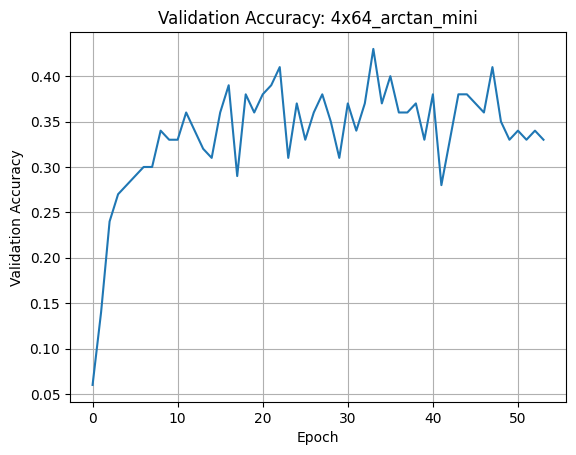

,Layers,Hidden Size,Activation,Batch Mode,Updates,Train Time (s),Test Accuracy
0,2,16,sigmoid,full,21,7.06,10.0
1,2,16,sigmoid,mini,64,20.79,28.0
2,2,16,relu,full,21,6.12,10.0
3,2,16,relu,mini,21,6.99,12.0
4,2,16,arctan,full,58,22.87,19.0
5,2,16,arctan,mini,39,16.76,31.0
6,3,16,sigmoid,full,21,8.26,10.0
7,3,16,sigmoid,mini,76,29.86,19.0
8,3,16,relu,full,21,7.81,10.0
9,3,16,relu,mini,21,7.90,10.0


In [ ]:
"""
The model accepts 49-dimensional inputs from 7x7 downscaled images and has hidden layers
between 2 to 4 layers, each with 16,32, or 64 neurons. It also uses three different
activation functions and uses softmax on the final output layer. There is a training
loop both full-batch and mini-batch and the loss is computed using cross-entropy using
one-hot encoded labels and log softmax output. The training also uses gradient descent to
manually update the weights using .backward() and torch.no_grad() to compute the gradients.
The early stopping is also applied when the validation accuracy doesn't improve for 20
iterations. Finally the validation accuracy is computed and plotted aftward.
"""

import matplotlib.pyplot as plt
import time

# The architecture of a neural network
class NeuralNetwork:
  def __init__(self, input_size, hidden_size, num_layers, activation_func):
    self.num_layers = num_layers # number of hidden layers (2,3,4)
    self.activation_func = activation_func # Exploring the three different functions
    self.weights = []
    self.biases = []

    # Initialize the weight and bias, all hidden layers initialized
    last_size = input_size
    for _ in range(num_layers):
      # Empty weight matrix W
      W = torch.empty((hidden_size, last_size)).uniform_(-1, 1).requires_grad_()
      # Create bias vector b
      b = torch.empty(hidden_size).uniform_(-1, 1).requires_grad_()
      self.weights.append(W)
      self.biases.append(b)
      last_size = hidden_size # set for the next layer

    # Output layer, so the network ends with 10 neurons
    W = torch.empty((10, last_size)).uniform_(-1, 1).requires_grad_()
    b = torch.empty(10).uniform_(-1, 1).requires_grad_()
    self.weights.append(W)
    self.biases.append(b)

  # Compute the output of the neural network for an input x
  def forward(self, x):
    out = x
    for i in range(self.num_layers):
      out = self.activation_func(torch.matmul(self.weights[i], out) + self.biases[i])
    # Uses softmax on the final layer
    out = torch.softmax(torch.matmul(self.weights[-1], out) + self.biases[-1], dim=0)
    return out

  # Returns a list of all the model's parameters
  def parameters(self):
    return self.weights + self.biases

# Stop when the accuracy no longer appears to be improving
def train_model(model, x_train, y_train, x_val, y_val, learning_rate=0.02, batch_size=None, max_epochs=500):
  # Convert the numpy arrays to PyTorch tensors for gradient tracking
  train_x = torch.tensor(x_train, dtype=torch.float32)
  train_y = torch.tensor(y_train, dtype=torch.long)
  val_x = torch.tensor(x_val, dtype=torch.float32)
  val_y = torch.tensor(y_val, dtype=torch.long)

  history = [] # stores validation accurancy over time
  best_val_acc = 0 # keeps track of best validation accuracy
  epochs_without_improve = 0 # tracks if validation stopped improving

  start_time = time.time() # Start time for training the model

  # Loop over the epochs
  for epoch in range(max_epochs):
    # Use a full batch size, if batch size is no specified
    if batch_size is None:
      x_batch = train_x
      y_batch = train_y

      loss = 0
      for i in range(x_batch.shape[0]):
        out = model.forward(x_batch[i])
        y_onehot = torch.zeros(10)
        y_onehot[y_batch[i]] = 1.0
        loss += -torch.sum(y_onehot * torch.log(out + 1e-9))
      loss = loss / x_batch.shape[0]

      loss.backward()
      with torch.no_grad():
        for param in model.parameters():
          param -= learning_rate * param.grad
          param.grad.zero_()

    # Use a mini-batch size
    else:
      # Randomly choose an image
      perm = torch.randperm(train_x.shape[0])
      x_shuffled = train_x[perm]
      y_shuffled = train_y[perm]

      # Uses the batch size
      for i in range(0, train_x.shape[0], batch_size):
        x_batch = x_shuffled[i:i + batch_size]
        y_batch = y_shuffled[i:i + batch_size]

        # Forward pass
        loss = 0
        for j in range(x_batch.shape[0]):
          out = model.forward(x_batch[j])
          y_onehot = torch.zeros(10)
          y_onehot[y_batch[j]] = 1.0
          loss += -torch.sum(y_onehot * torch.log(out + 1e-9))
        loss = loss / x_batch.shape[0]

        # Backward pass to compute the gradients automatically
        loss.backward()

        # Update the weights
        with torch.no_grad():
          for param in model.parameters():
            param -= learning_rate * param.grad
            param.grad.zero_()

    # Validation accuracy
    val_preds = []
    for i in range(val_x.shape[0]):
      out = model.forward(val_x[i])
      val_preds.append(torch.argmax(out).item())
    val_preds = torch.tensor(val_preds)
    val_acc = (val_preds == val_y).float().mean().item()
    history.append(val_acc)

    # Early stopping
    if val_acc > best_val_acc: # When the validation accuracy improves
      best_val_acc = val_acc # set the better validation accuracy value
      epochs_without_improve = 0 # reset the counter
    else:
      epochs_without_improve += 1
      # The training will stop once the accuracy hasn't improved for 20 iterations
      if epochs_without_improve >= 20:
        break

  # Obtain the total time it took to train the model
  total_time = time.time() - start_time
  return history, total_time, epoch+1, best_val_acc

def plot_history(history, title):
  plt.plot(history)
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Validation Accuracy')
  plt.show()

# Subset configs to reduce memory usage
hidden_sizes = [16, 32, 64] # neurons
num_layers_options = [2, 3, 4] # Varying layers from 2-4
# Different type of activations
activations = {
    "sigmoid": torch.sigmoid,
    "relu": torch.relu,
    "arctan": torch.atan
}

# Different batch sizes
batch_modes = ["full", "mini"]

# Preprocessing data and flattening images
train_x, train_y, val_x, val_y, test_x, test_y = preprocess_data(size)

# Flatten the images
train_x_flat = flatten_images(train_x)
val_x_flat = flatten_images(val_x)
test_x_flat = flatten_images(test_x)
input_size = train_x_flat.shape[1] # 7x7 version of the data

results = []
all_histories = {} # All the histories

# Loop through hidden sizes
for hidden_size in hidden_sizes:
    for num_layers in num_layers_options: # Loop through the layers
        for act_name, act_func in activations.items(): # Loop through the activation layers
            for mode in batch_modes: # Loop through the different batch sizes
                # Create the model
                model = NeuralNetwork(input_size, hidden_size, num_layers, act_func)
                batch_size = None if mode == "full" else 100
                history, training_time, updates, best_val = train_model(
                    model, train_x_flat, train_y, val_x_flat, val_y,
                    learning_rate=0.02, batch_size=batch_size, max_epochs=500
                )

                # The prediction accuracies
                test_preds = []
                for i in range(test_x.shape[0]):
                    out = model.forward(torch.tensor(test_x[i].flatten(), dtype=torch.float32))
                    test_preds.append(torch.argmax(out).item())
                test_acc = np.mean(np.array(test_preds) == test_y)

                # Used for figure out which plot to display
                key = f"{num_layers}x{hidden_size}_{act_name}_{mode}"
                all_histories[key] = history

                # Append the results
                results.append({
                    "Layers": num_layers,
                    "Hidden Size": hidden_size,
                    "Activation": act_name,
                    "Batch Mode": mode,
                    "Updates": updates,
                    "Train Time (s)": round(training_time, 2),
                    "Test Accuracy": round(test_acc * 100, 2)
                })

# Plotting when the validation data accuracy is going down during the training process
plot_key = list(all_histories.keys())[53]
plt.plot(all_histories[plot_key])
plt.title(f"Validation Accuracy: {plot_key}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

# Display table of the results
df_results = pd.DataFrame(results)
df_results


# Results Report:
The best architecture for this neural network was 4 hidden layers, with an arctan activation function, and using a mini batch with a size of 100, resulting in an accuracy of 51%. Adding too many layers would cause overfitting which could potentially reduce accuracy. Also, increasing the number of neurons resulted in better accuracy. The mini batches did help since the accuracy was much better since it oftwen resulted in higher test accuracies, especially for deeper networks. The training time was also much faster since there was fewer samples processed at a time. The mini-batches allowed more stable learning and converge to better minima. However, for smaller configurations, the full batch performed much better in stability since there was fewer updates.

The early stop condition that I applied was that when the validation accuracy failed to improve for 20 epochs or interations, then it would stop. In the plot you can see that once it hit 54 iterations thats when the validation accuracy started to plateau and began to decrease. This might be because of overfitting or the model converged. Thus validating that the early stopping condition was effective.